<img src="logo_UTN.svg" align="right" width="150" /> 

## Teoría de Circuitos II

### Tarea Semanal 9

#### Por Matías Marfisi


# Consigna

![Consigna](Consigna1.png "Consigna")

![Consigna](Consigna2.png "Consigna")

## Simulación

### Inicialización

In [2]:
# Módulos para Jupyter

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
#%%  Inicialización de librerías
# Setup inline graphics: Esto lo hacemos para que el tamaño de la salida, 
# sea un poco más adecuada al tamaño del documento
mpl.rcParams['figure.figsize'] = (25,15)

#%% Esto tiene que ver con cuestiones de presentación de los gráficos,
# NO ES IMPORTANTE
fig_sz_x = 14
fig_sz_y = 13
fig_dpi = 80 # dpi

#fig_font_family = 'Ubuntu'
fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})
#plt.rcParams.update({'font.family':fig_font_family})

# módulo de SciPy
from scipy import signal as sig

# un módulo adaptado a mis necesidades
from splane import analyze_sys, pretty_print_bicuad_omegayq, plot_plantilla

In [3]:
def group_delay(ww, phase):
    
    groupDelay = -np.diff(phase)/np.diff(ww)
    
    return(np.append(groupDelay, groupDelay[-1]))

### Filtro IIR

C:\Users\matim\AppData\Local\Temp/ipykernel_13156/3741804722.py:26: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(np.abs(h)), label='Cheby1 IIR')


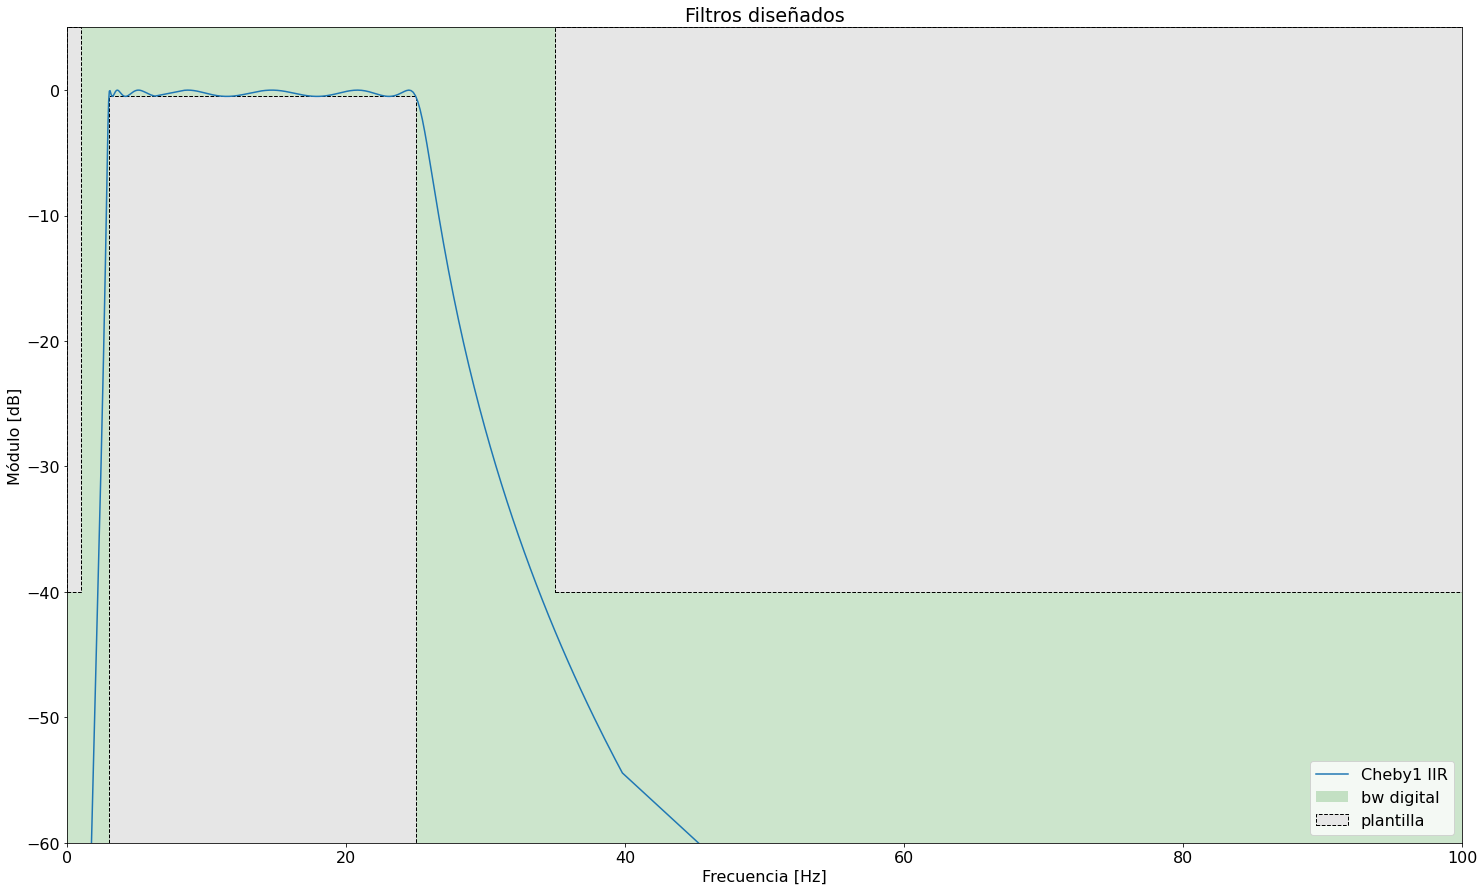

(0.0, 100.0)

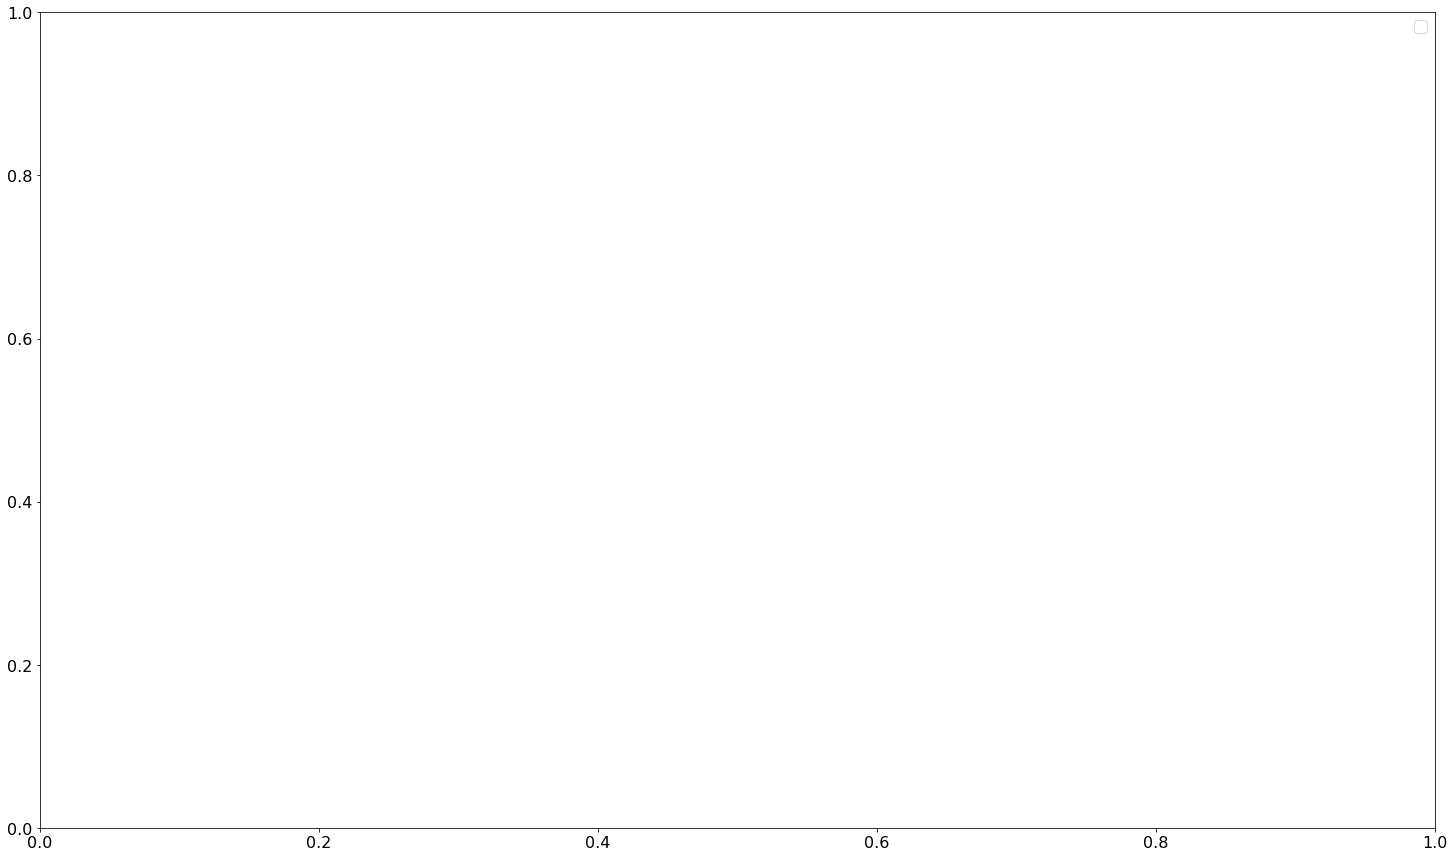

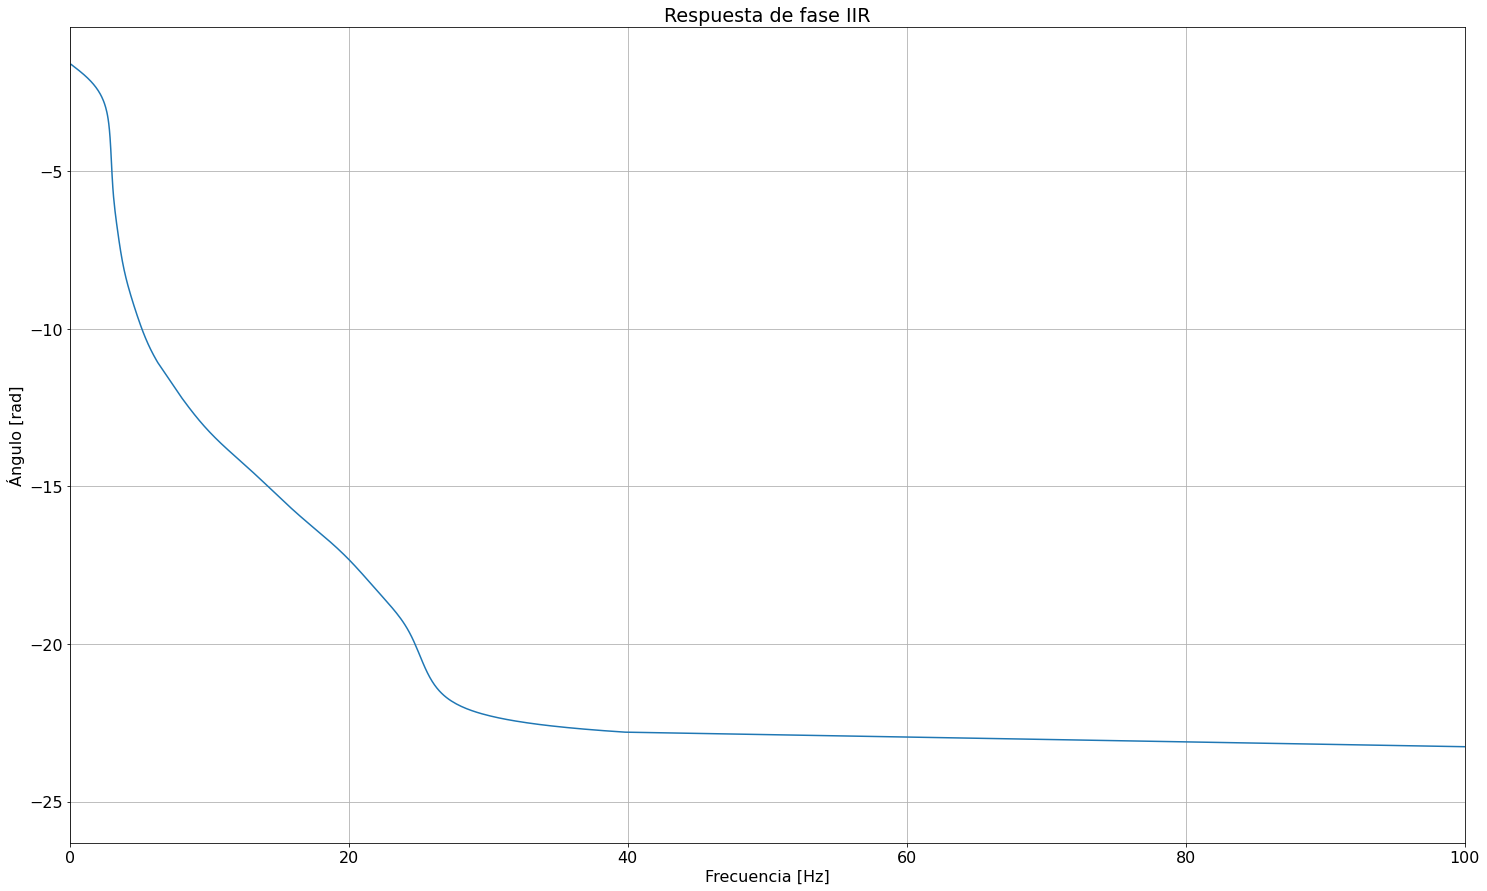

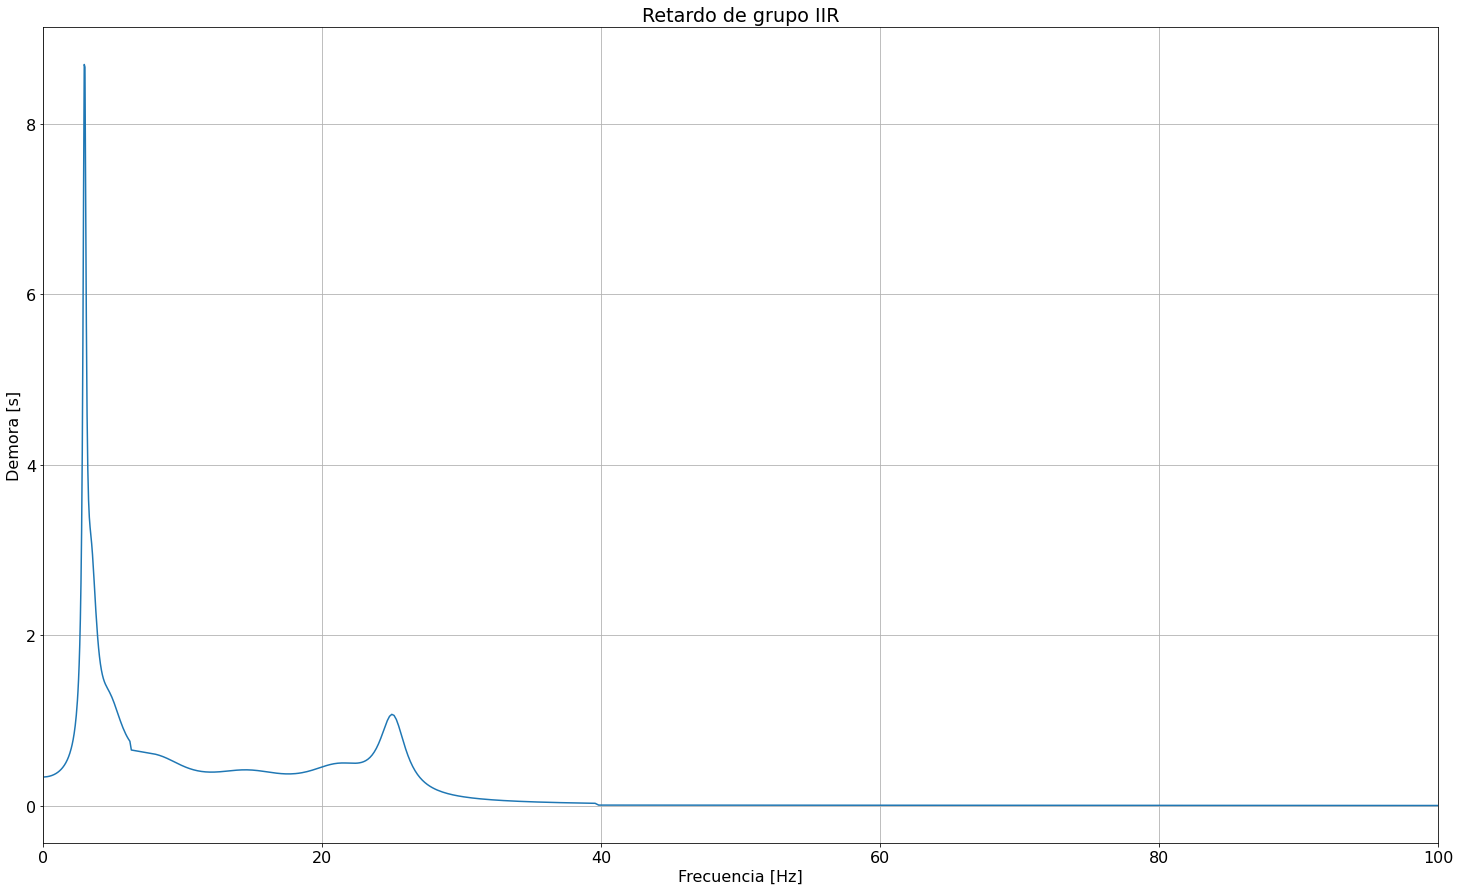

In [8]:
fs = 1e3
f_to_w = 2*np.pi
f_pass = np.array([3, 25])
f_stop = np.array([1, 35])
at_pass = 0.5
at_stop = 40
f_nyq = fs / 2
#orden = sig.buttord(f_pass * f_to_w, f_stop * f_to_w, at_pass, 50, analog = False, fs = fs)
#sos_iir = sig.butter(orden[0], (f_pass[0], f_pass[1]), 'bandpass', analog = False, output = 'sos', fs = fs)
sos_iir = sig.iirdesign(f_pass / fs, f_stop / fs, at_pass, at_stop, analog = False, ftype = 'cheby1', output = 'sos', fs = 1)
#sos_iir = sig.iirfilter(10, f_pass, btype = 'bandpass', analog = False, ftype = 'cheby1', rp = at_pass, output = 'sos', fs = fs)

w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, f_nyq, 100, endpoint=True) ) / f_nyq * np.pi
_, h = sig.sosfreqz(sos_iir, w)
# Renormalizo el eje de frecuencia
w = w / np.pi * f_nyq

#w, h = sig.sosfreqz(sos_iir, fs = fs)

# Modulo
plt.axis([0, 100, -60, 5 ]);
plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.plot(w, 20 * np.log10(np.abs(h)), label='Cheby1 IIR')
plot_plantilla(filter_type = 'bandpass', fpass = f_pass, ripple = 0.5 , fstop = f_stop, attenuation = at_stop, fs = fs)
plt.legend('IIR')

# Fase
plt.figure()
plt.title('Respuesta de fase IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Ángulo [rad]')
fase_iir = np.unwrap(np.angle(h))
plt.plot(w, fase_iir)
plt.grid(which='both', axis='both')
#plt.axis([0, 100, -25, 5 ]);
plt.xlim(0, 100)

# Retardo
gd_iir = group_delay(w, fase_iir)
plt.figure()
plt.title('Retardo de grupo IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Demora [s]')
plt.plot(w, gd_iir)
plt.grid(which='both', axis='both')
plt.xlim(0, 100)
#plt.axis([0, 100, -3, 3 ]);

#plot_plantilla(filter_type = 'bandpass', fpass = f_pass, attenuation = at_stop, fstop = f_stop, fs = fs)

### Filtro FIR (firwin2)

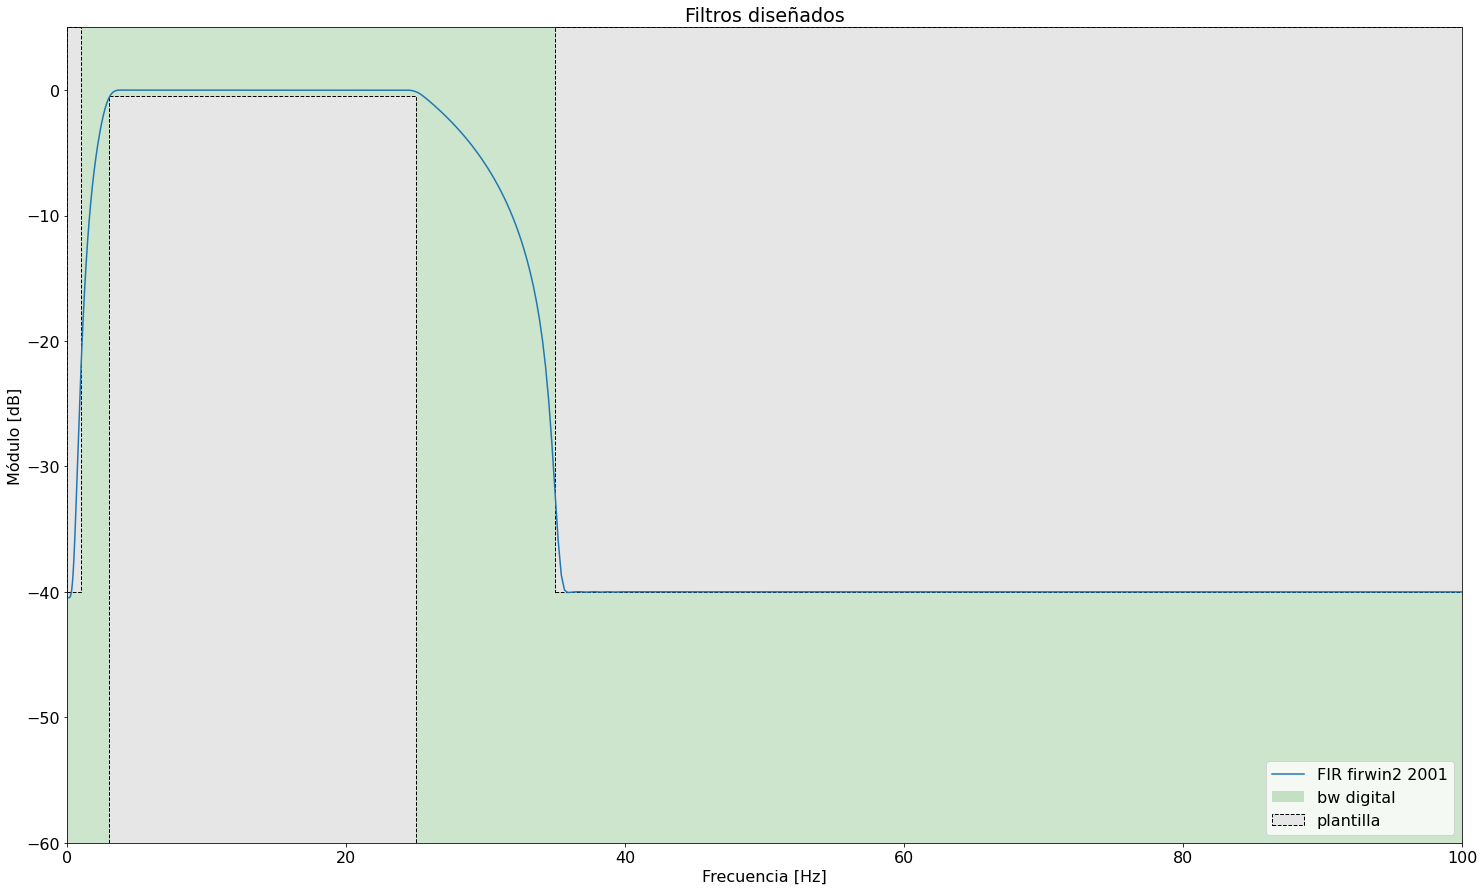

(0.0, 100.0)

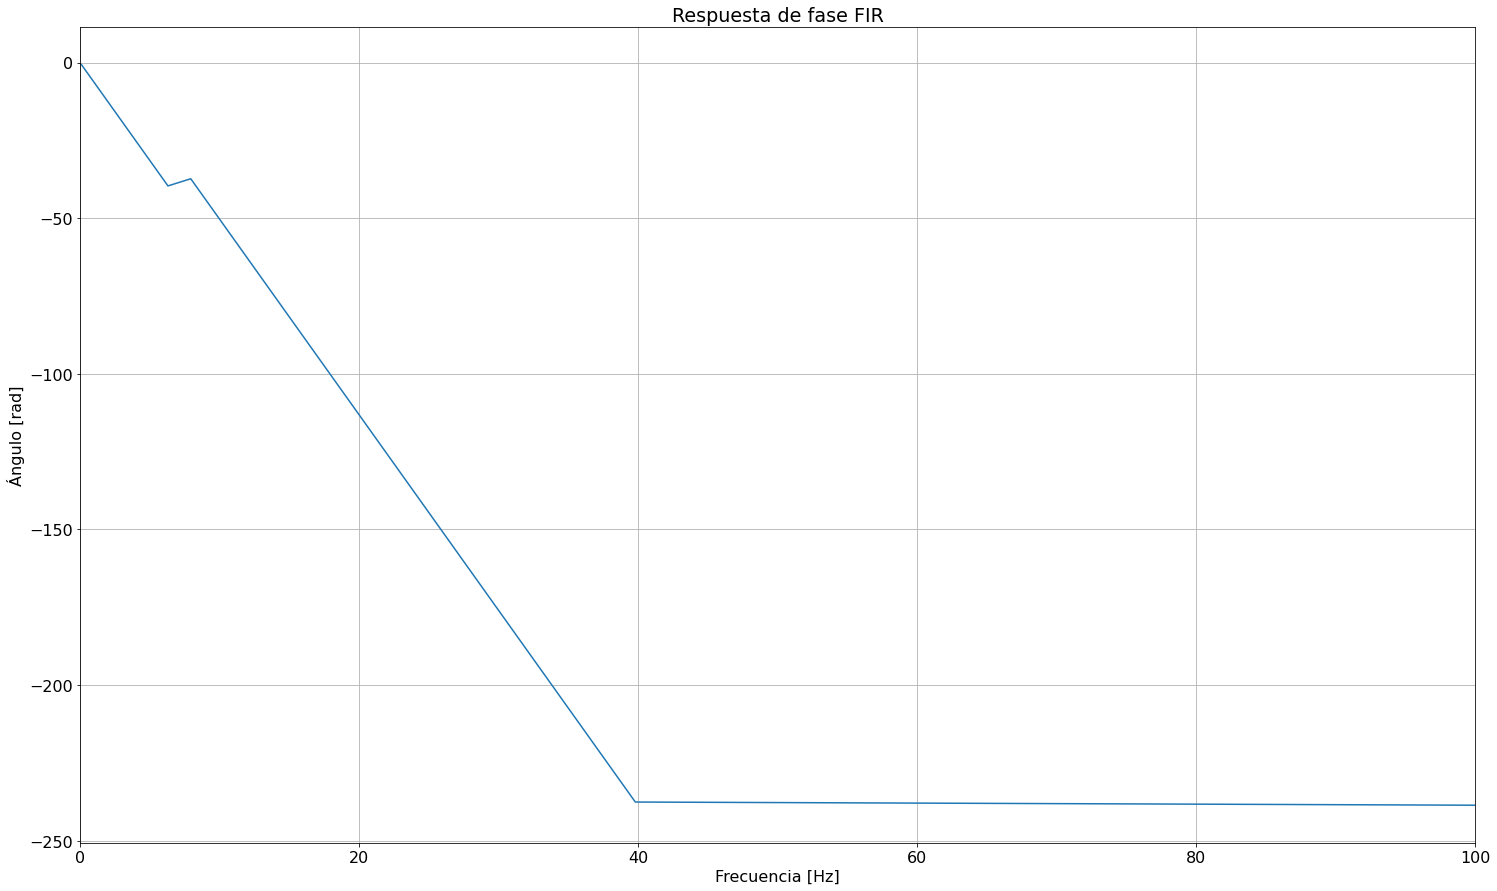

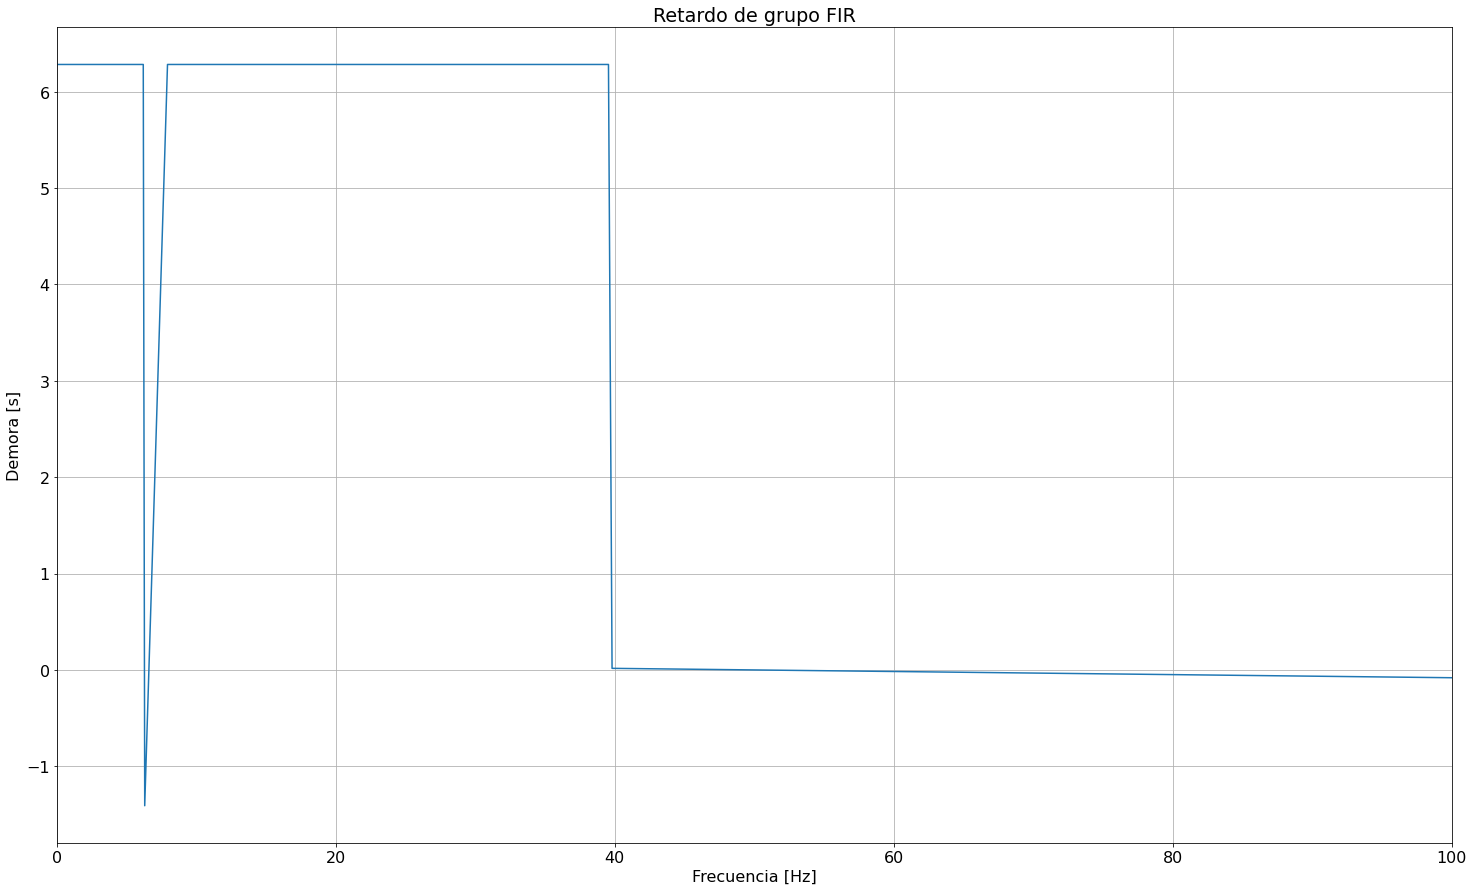

In [5]:
# Parametros de diseño FIR
fs = 1e3
f_to_w = 2*np.pi

at_pass = 0.5
at_stop = 40
fs1 = 1
fp1 = 3
fp2 = 25
fs2 = 35

f_nyq = fs / 2
freqs = np.array([0, fs1, fp1, fp2, fs2, f_nyq]) / f_nyq
#print(freqs)
gains = np.array([-at_stop, -at_stop, -0, -0, -at_stop, -at_stop])
gains = 10**(gains/20)

# Diseño
coefs = 2001
num_fir = sig.firwin2(coefs, freqs, gains)
den_fir = 1

w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, f_nyq, 100, endpoint=True) ) / f_nyq * np.pi
_, h = sig.freqz(num_fir, den_fir, w)
# Renormalizo el eje de frecuencia
w = w / np.pi * f_nyq

# Modulo
plt.axis([0, 100, -60, 5 ]);
plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.plot(w, 20 * np.log10(np.abs(h)), label='FIR firwin2 2001')
plt.legend('FIR')
plot_plantilla(filter_type = 'bandpass', fpass = f_pass, ripple = at_pass , fstop = f_stop, attenuation = at_stop, fs = fs)

# Fase
plt.figure()
plt.title('Respuesta de fase FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Ángulo [rad]')
fase_fir = np.unwrap(np.angle(h))
#fase_fir = np.angle(h)
plt.plot(w, fase_fir)
plt.grid(which='both', axis='both')
plt.xlim(0, 100)
#plt.axis([0, 100, -25, 5 ]);

# Retardo
gd_iir = group_delay(w, fase_fir)
plt.figure()
plt.title('Retardo de grupo FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Demora [s]')
plt.plot(w, gd_iir)
plt.grid(which='both', axis='both')
plt.xlim(0, 100)
#plt.axis([0, 100, -2, 7 ]);


### Filtro FIR (remez)

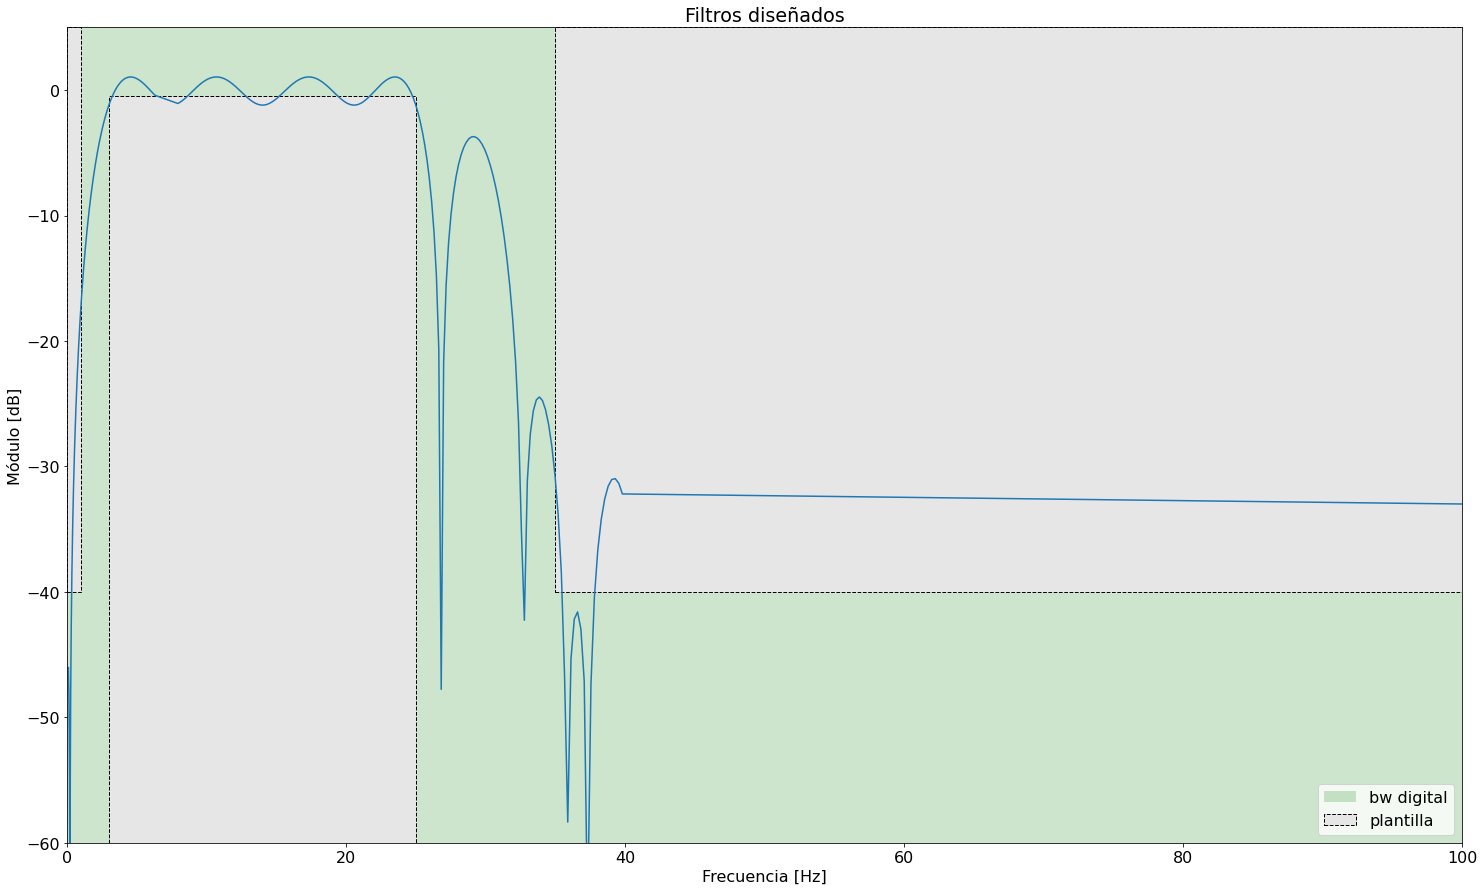

(0.0, 100.0)

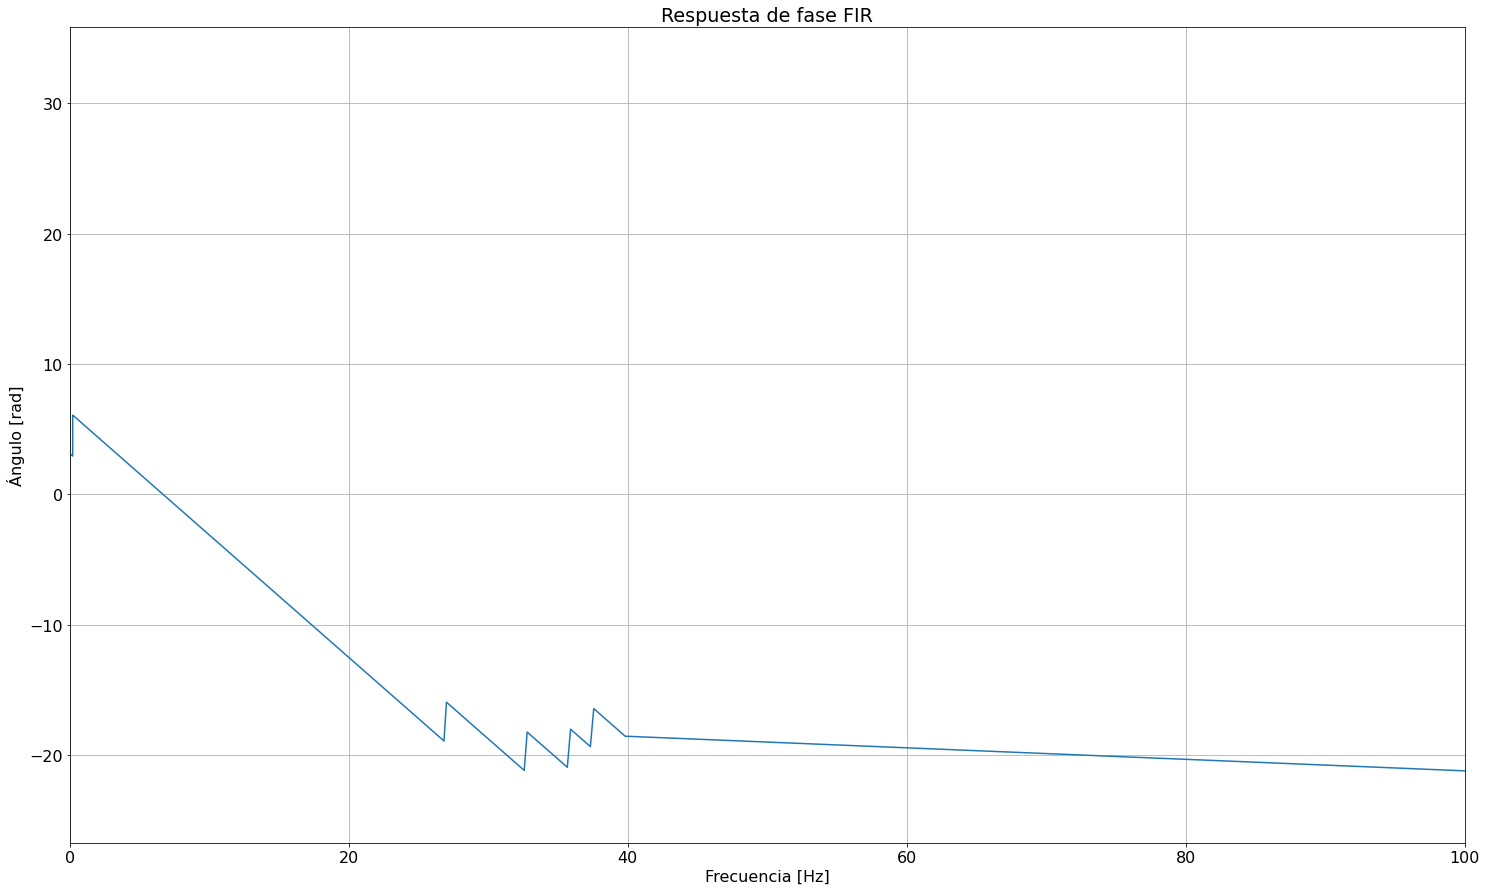

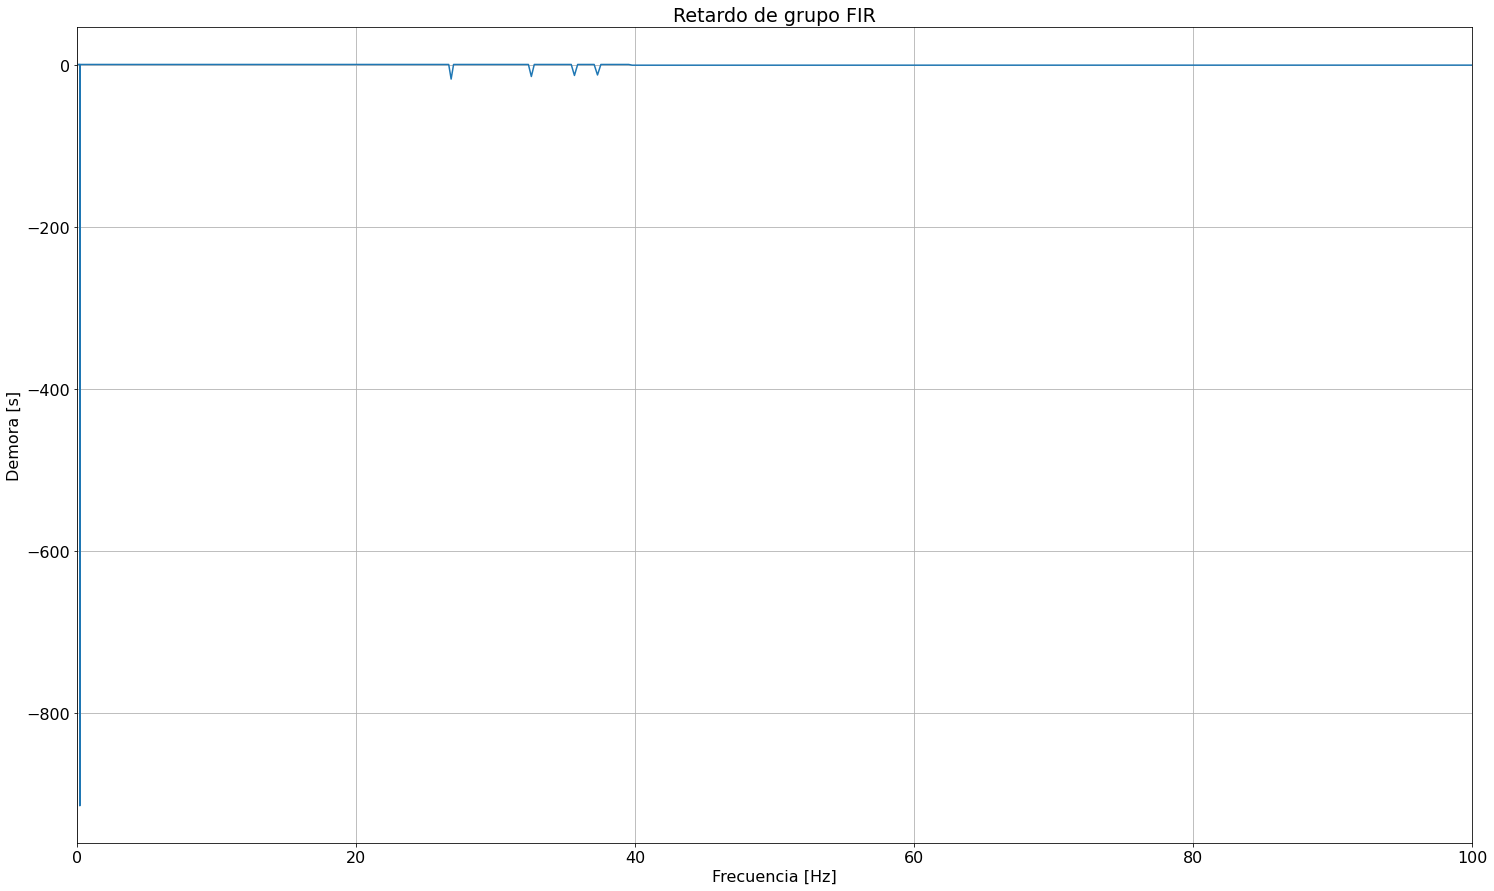

In [35]:
# Parametros de diseño FIR
fs = 1e3
f_to_w = 2*np.pi

at_pass = 0.5
at_stop = 40
fs1 = 1
fp1 = 3
fp2 = 25
fs2 = 35

f_nyq = fs / 2
freqs = np.array([0, fs1, fp1, fp2, fs2, f_nyq])
#freqs_hp = np.array([])
gains_remez = np.array([-at_stop, -0, -at_stop])
gains_remez = 10**(gains_remez/20)

#np.seterr(divide='ignore', invalid='ignore')
# Diseño con remez, un LP y un HP
coefs = 300
# Defino un peso para cada banda de la plantilla, minimizo el error, defino que error pesar más
weights = np.array([1, 1, 7])
num_fir_remez = sig.remez(coefs, freqs, gains_remez, fs=fs, weight = weights, grid_density = 2000)

#print(num_fir)
den_fir = 1

w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, f_nyq, 100, endpoint=True) ) / f_nyq * np.pi
_, h = sig.freqz(num_fir_remez, den_fir, w)
# Renormalizo el eje de frecuencia
w = w / np.pi * f_nyq
#w, h = sig.freqz(num_fir, den_fir, 2048)

# Modulo
plt.axis([0, 100, -60, 5 ]);
plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.plot(w, 20 * np.log10(np.abs(h)))
plt.legend('FIR')
plot_plantilla(filter_type = 'bandpass', fpass = f_pass, ripple = at_pass , fstop = f_stop, attenuation = at_stop, fs = fs)

# Fase
plt.figure()
plt.title('Respuesta de fase FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Ángulo [rad]')
fase_fir = np.unwrap(np.angle(h))
#fase_fir = np.angle(h)
plt.plot(w, fase_fir)
plt.grid(which='both', axis='both')
plt.xlim(0, 100)
#plt.axis([0, 100, -25, 5 ]);

# Retardo
gd_iir = group_delay(w, fase_fir)
plt.figure()
plt.title('Retardo de grupo FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Demora [s]')
plt.plot(w, gd_iir)
plt.grid(which='both', axis='both')
plt.xlim(0, 100)
#plt.axis([0, 100, -2, 7 ]);


### Implementación de los filtros

Se utiliza una señal de ECG para evaluar los filtros.

#### FIR e IIR para distintas zonas

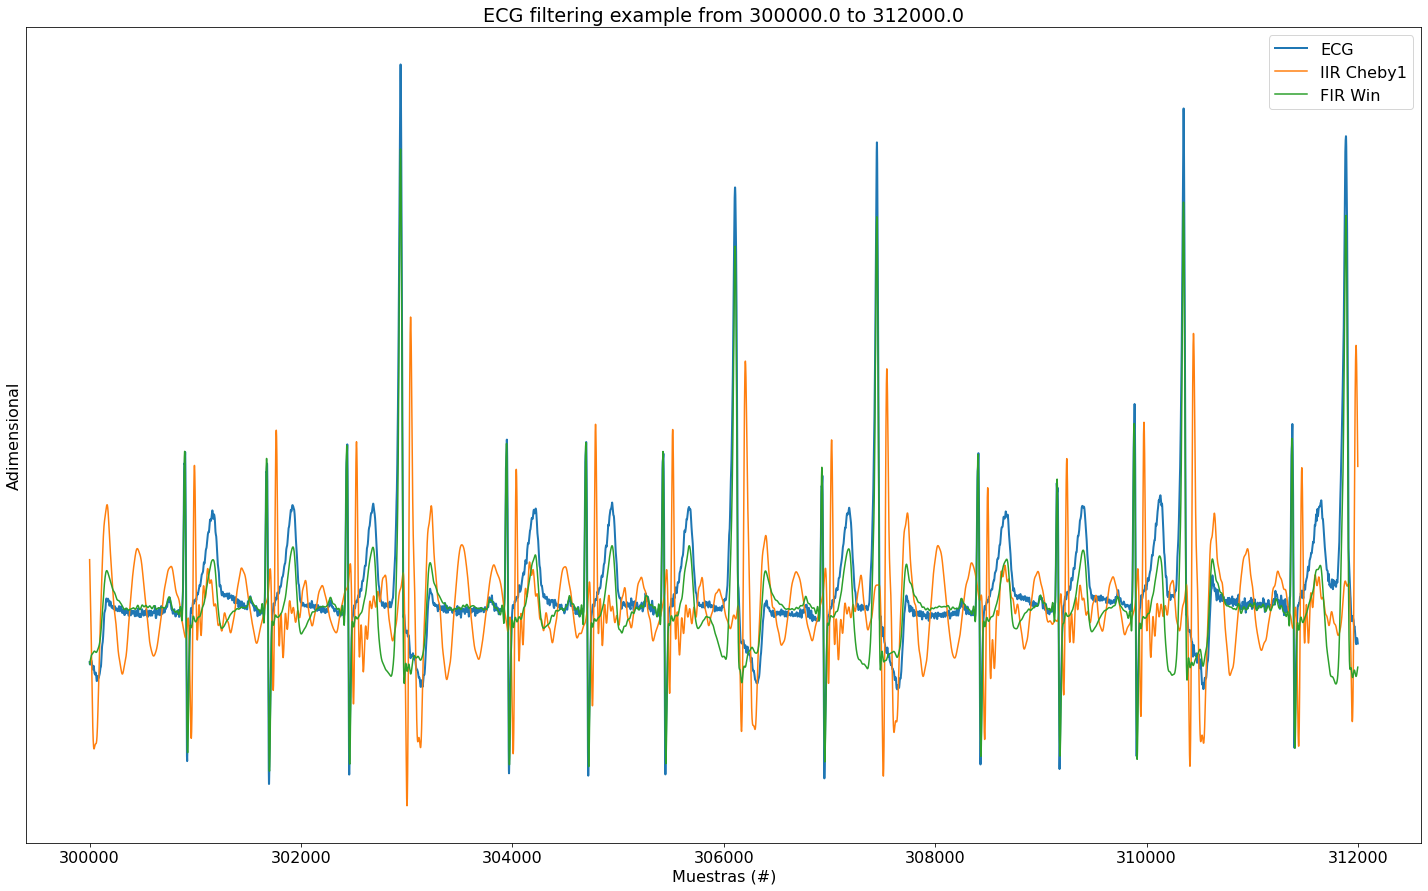

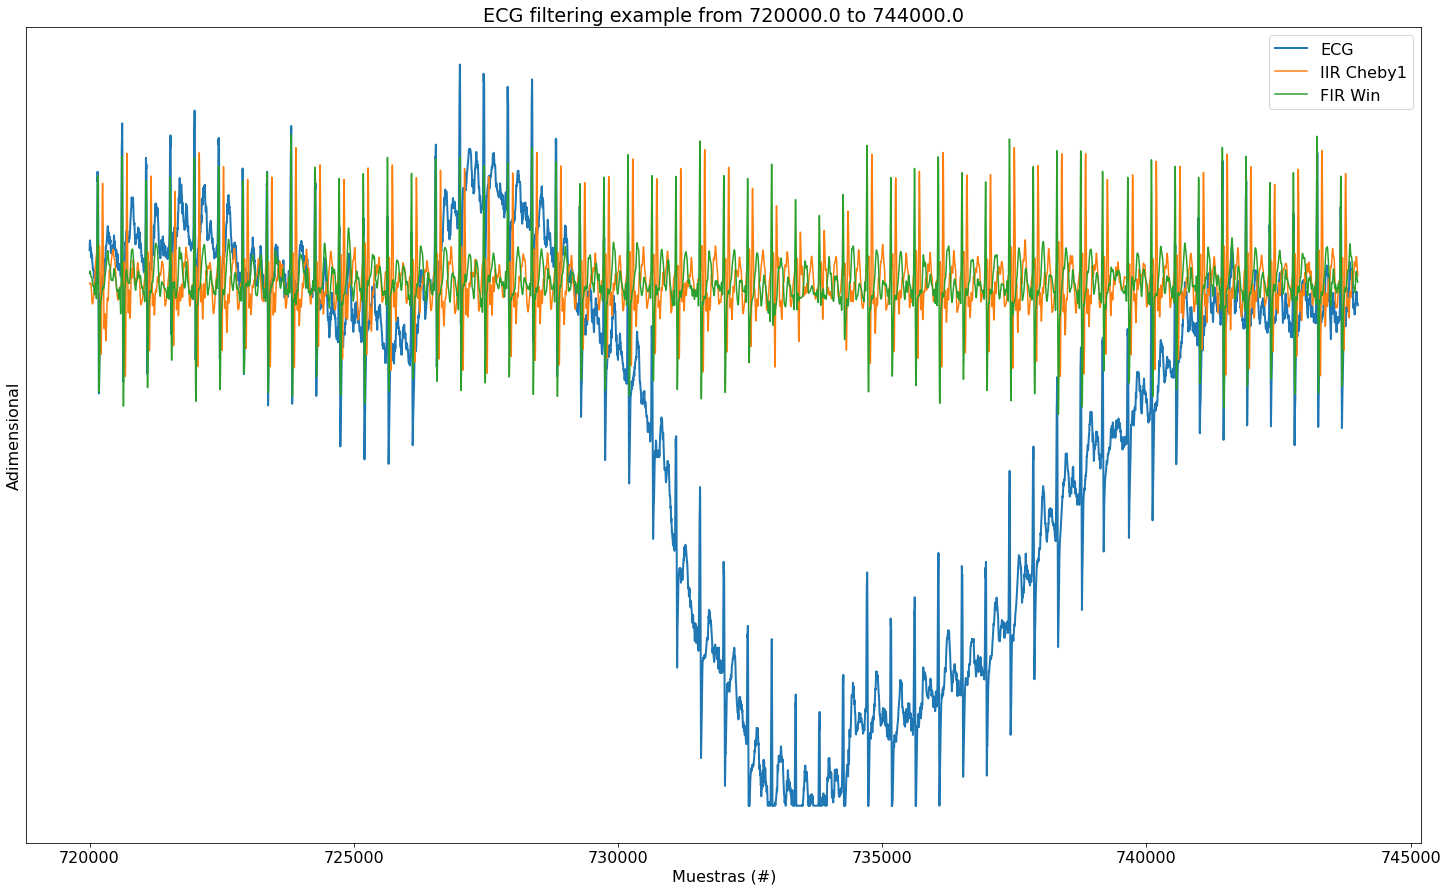

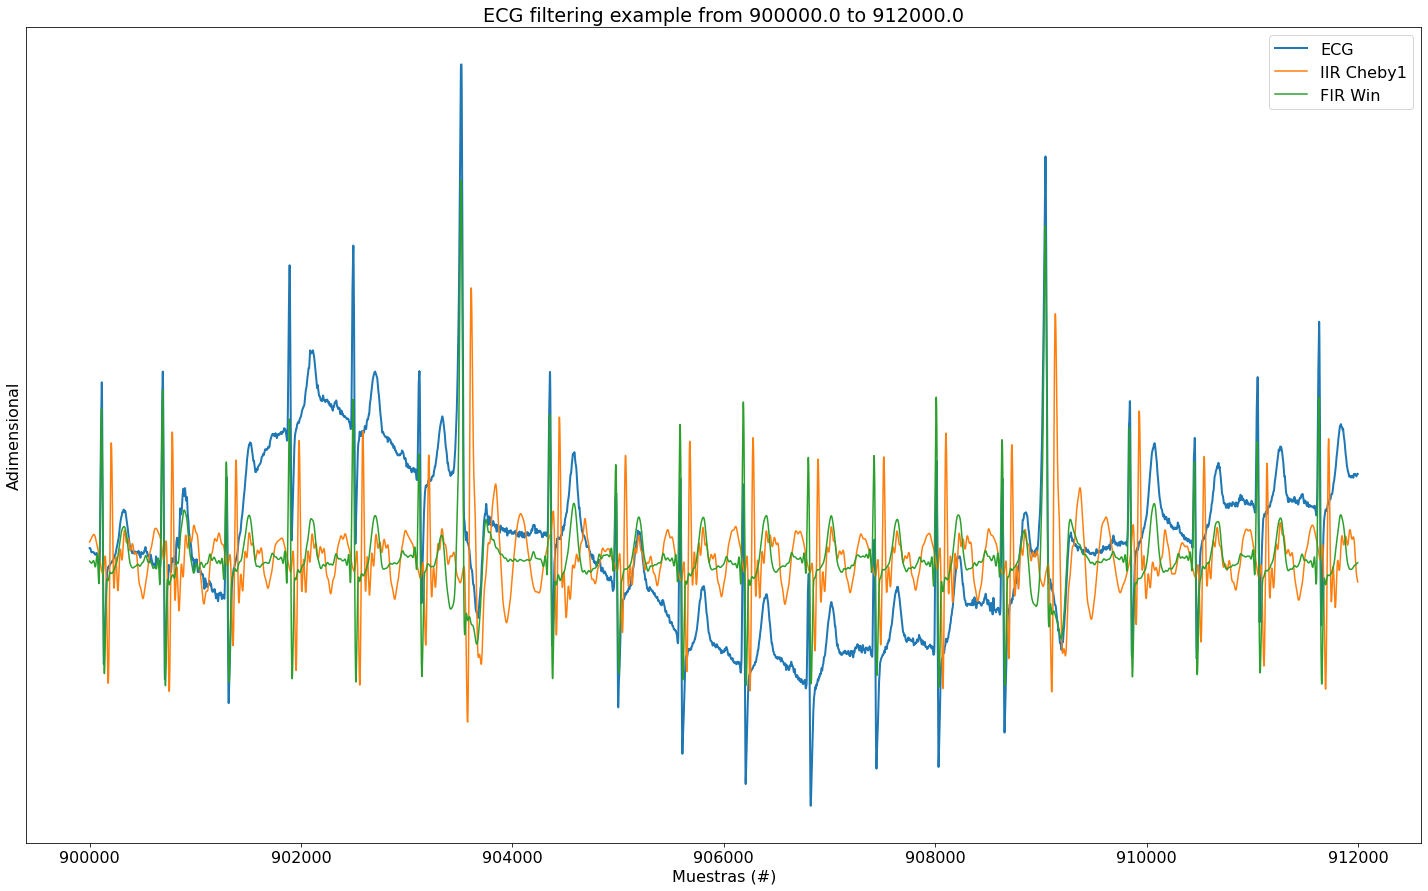

In [49]:
import scipy.io as sio
###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

# FIR
ECG_f_win = sig.lfilter(num_fir, den_fir, ecg_one_lead)
# IIR
ECG_f_cheby = sig.sosfilt(sos_iir, ecg_one_lead)

demora = 1000

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    #plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_cheby[zoom_region], label='IIR Cheby1')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='FIR Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

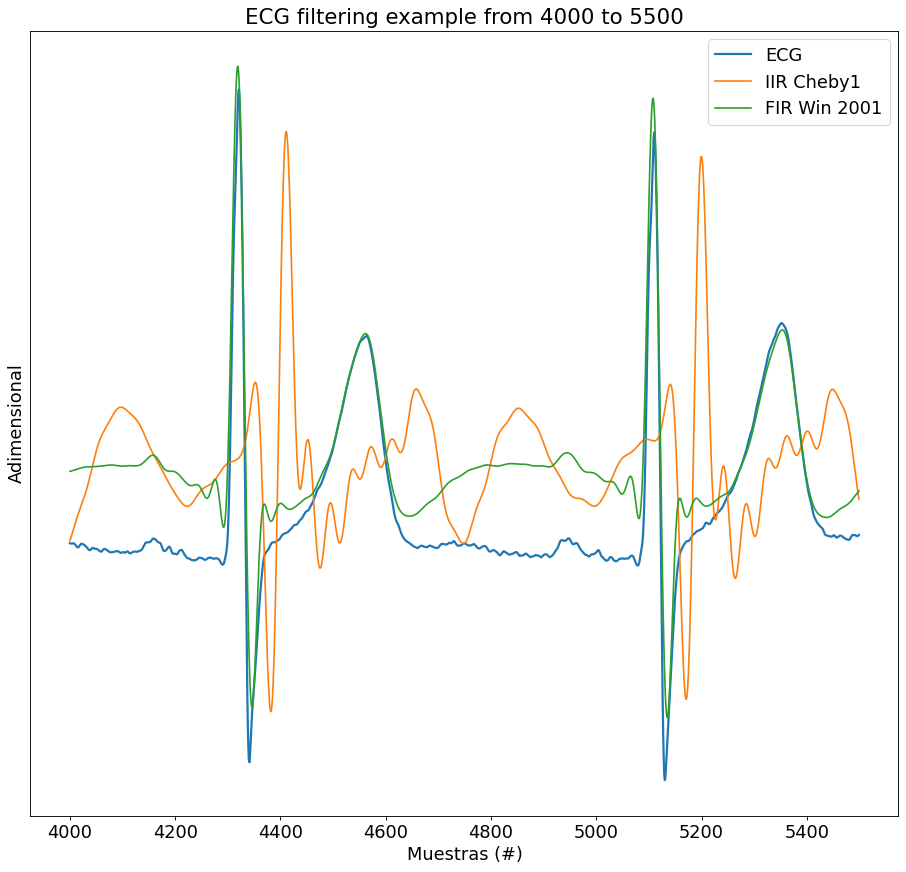

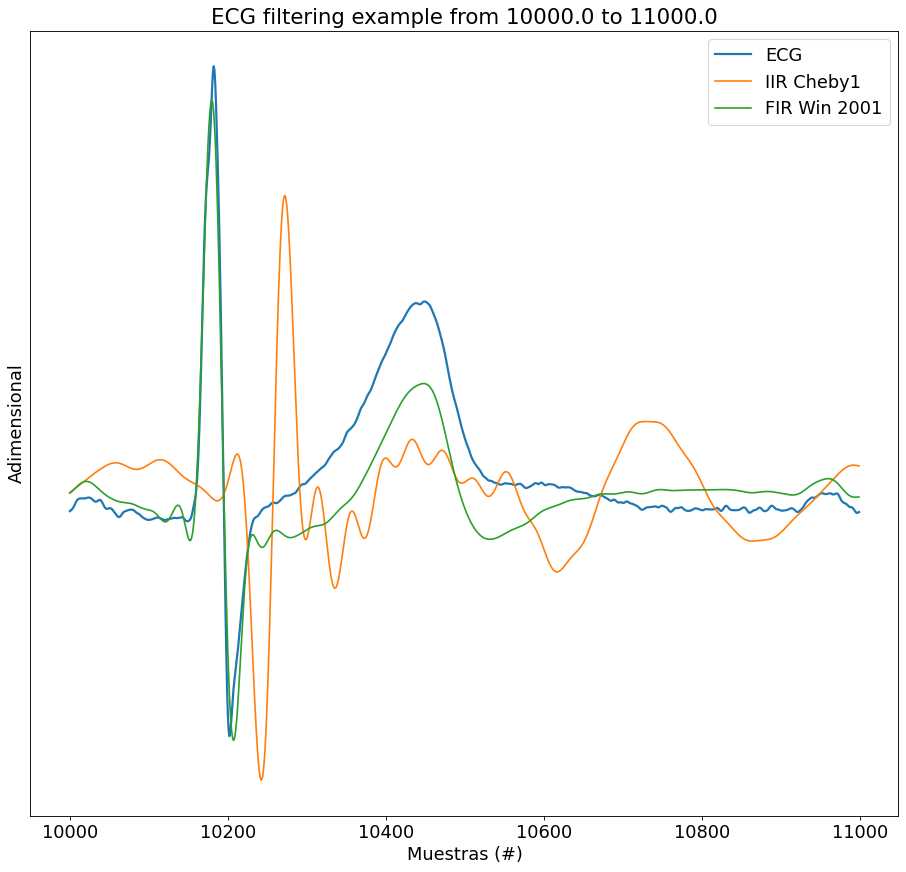

In [50]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_cheby[zoom_region], label='IIR Cheby1')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='FIR Win 2001')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Evaluando los resultados obtenidos, podríamos ajustar la plantilla del filtro I